# Phenantherene

In [1]:
from pyscf import gto

def load_xyz_atoms(path: str):
    """
    Read an XYZ file and return a list of [element, (x, y, z)] entries.
    """
    with open(path) as f:
        lines = f.readlines()
    
    natoms = int(lines[0].strip())
    atom_lines = lines[2 : 2 + natoms]

    atoms = []
    for L in atom_lines:
        parts = L.split()
        sym = parts[0]
        x, y, z = map(float, parts[1:4])
        atoms.append([sym, (x, y, z)])
    return atoms

## Exact Energy Calculation with RHF and CCSD

In [2]:
import warnings
warnings.filterwarnings("ignore")

from pyscf import gto, scf, cc, mcscf, ao2mo

# Specify molecule properties
open_shell = False
spin_sq = 0

atoms = load_xyz_atoms("Phenanthrene.xyz")

mol = gto.Mole()
mol.build(
    atom=atoms,
    basis="6-31g",
    symmetry=False,
)

print(f"Phenanthrene: {mol.natm} atoms, {mol.nao_nr()} AOs")

# Define active space
#   – Core: each C has a deep 1s orbital → 14 core orbitals
#   – Active: the 14 π MOs around the HOMO/LUMO (phenanthrene has 14 π-electrons)

# π‐orbitals near HOMO
mf = scf.RHF(mol).run()
mo_occ  = mf.mo_occ
homo_i  = max(i for i,o in enumerate(mo_occ) if o>0)
# take 14 π‐orbitals centered on the HOMO/LUMO gap:
half = 14//2
active_orbs = list(range(homo_i - half, homo_i + half))
n_active = len(active_orbs)
#core_orbs = list(range(n_core))

# RHF
mf = scf.RHF(mol)
e_rhf = mf.kernel()
print(f"RHF energy: {e_rhf:.8f} Ha")

# CCSD with core frozen
ccsd_calc = cc.CCSD(mf, frozen=[i for i in range(mol.nao_nr()) if i not in active_orbs]).run()
print(f"CCSD corr energy: {ccsd_calc.e_corr:.8f} Ha")
print(f"CCSD total energy: {ccsd_calc.e_tot:.8f} Ha")

# 5) CASCI (i.e. CASSCF without orbital rotation) on (14e,14o)
#    Count active electrons
n_elec = int(sum(mf.mo_occ[i] for i in active_orbs))
n_alpha = (n_elec + mol.spin) // 2
n_beta  = (n_elec - mol.spin) // 2

cas = mcscf.CASCI(mf, n_active, (n_alpha, n_beta))
# sort MOs 
mo = cas.sort_mo(active_orbs, base=0)

# extract integrals in active space
h1, e_nuc = cas.get_h1cas(mo)
h2 = ao2mo.restore(1, cas.get_h2cas(mo), n_active)

# run CASCI
e_cas = cas.run(mo_coeff=mo).e_tot

Phenanthrene: 24 atoms, 146 AOs
converged SCF energy = -535.814637127013
converged SCF energy = -535.814637127012
RHF energy: -535.81463713 Ha
E(CCSD) = -535.8837607986571  E_corr = -0.06912367164532243
CCSD corr energy: -0.06912367 Ha
CCSD total energy: -535.88376080 Ha
CASCI E = -535.885152574924  E(CI) = -29.2822619660082  S^2 = 0.0000000


In [3]:
import ffsim
from qiskit import QuantumCircuit, QuantumRegister

# --- 1) Set up your active‐space size ---
num_orbitals = n_active           # e.g. 14 from your (14e,14o) CASCI

# --- 2) Grab your CCSD amplitudes (already computed) ---
#    from: ccsd_calc = cc.CCSD(mf, frozen=core_orbs).run()
t1 = ccsd_calc.t1
t2 = ccsd_calc.t2

# --- 3) Define how many repetitions and which orbital pairs to entangle ---
n_reps = 1
# here: next‐neighbor α–α couplings
alpha_alpha_indices = [(p, p + 1) for p in range(num_orbitals - 1)]
# every 4th α–β coupling (you can tune this)
alpha_beta_indices  = [(p, p)     for p in range(0, num_orbitals, 4)]

# --- 4) Build the spin‐balanced UCJ operator from those amplitudes ---
ucj_op = ffsim.UCJOpSpinBalanced.from_t_amplitudes(
    t2=t2,
    t1=t1,
    n_reps=n_reps,
    interaction_pairs=(alpha_alpha_indices, alpha_beta_indices),
)

# --- 5) Build the Qiskit circuit ---
qubits = QuantumRegister(2 * num_orbitals, name="q")  # JW uses 2×num_orbitals qubits
circuit = QuantumCircuit(qubits)

# 5a) Prepare the Hartree–Fock reference in Jordan–Wigner encoding
circuit.append(
    ffsim.qiskit.PrepareHartreeFockJW(num_orbitals, (n_alpha, n_beta)),
    qubits
)

# 5b) Apply the UCJ ansatz
circuit.append(
    ffsim.qiskit.UCJOpSpinBalancedJW(ucj_op),
    qubits
)

# 5c) Measure all qubits
circuit.measure_all()

In [4]:
# from qiskit_ibm_runtime.fake_provider import FakeSherbrooke

# backend = FakeSherbrooke()

In [5]:
from qiskit_ibm_runtime import QiskitRuntimeService
import json

with open("apikey.json", "r") as file:
    data = json.load(file)
    token = data["apikey"]
service = QiskitRuntimeService(channel='ibm_cloud', token=token)

backend = service.least_busy(operational=True, simulator=False)

qiskit_runtime_service._resolve_cloud_instances:WARNING:2025-07-13 04:07:47,579: Default instance not set. Searching all available instances.


In [7]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

spin_a_layout = [0, 14, 18, 19, 20, 33, 39, 40, 41, 53, 60, 61, 62, 72]
spin_b_layout = [2, 3, 4, 15, 22, 23, 24, 34, 43, 44, 45, 54, 64, 65]
initial_layout = spin_a_layout + spin_b_layout

pass_manager = generate_preset_pass_manager(
    optimization_level=3, backend=backend, initial_layout=initial_layout
)

# without PRE_INIT passes
isa_circuit = pass_manager.run(circuit)
print(f"Gate counts (w/o pre-init passes): {isa_circuit.count_ops()}")

# with PRE_INIT passes
# We will use the circuit generated by this pass manager for hardware execution
pass_manager.pre_init = ffsim.qiskit.PRE_INIT
isa_circuit = pass_manager.run(circuit)
print(f"Gate counts (w/ pre-init passes): {isa_circuit.count_ops()}")

Gate counts (w/o pre-init passes): OrderedDict([('sx', 5180), ('rz', 3145), ('cz', 2187), ('x', 407), ('measure', 28), ('barrier', 1)])
Gate counts (w/ pre-init passes): OrderedDict([('sx', 3372), ('rz', 1913), ('cz', 1417), ('x', 108), ('measure', 28), ('barrier', 1)])


In [ ]:
import numpy as np
from qiskit_addon_sqd.counts import generate_bit_array_uniform
from qiskit_ibm_runtime import SamplerV2 as Sampler

sampler = Sampler(mode=backend)
job = sampler.run([isa_circuit], shots=10_000)
primitive_result = job.result()
pub_result = primitive_result[0]
bit_array = pub_result.data.meas

rng = np.random.default_rng(24)
# bit_array = generate_bit_array_uniform(10_000, num_orbitals * 2, rand_seed=rng)

In [ ]:
from functools import partial

from qiskit_addon_sqd.fermion import SCIResult, diagonalize_fermionic_hamiltonian, solve_sci_batch

# SQD options
energy_tol = 1e-3
occupancies_tol = 1e-3
max_iterations = 20

# Eigenstate solver options
num_batches = 1
samples_per_batch = 300
symmetrize_spin = True
carryover_threshold = 1e-4
max_cycle = 200

# Pass options to the built-in eigensolver. If you just want to use the defaults,
# you can omit this step, in which case you would not specify the sci_solver argument
# in the call to diagonalize_fermionic_hamiltonian below.
sci_solver = partial(solve_sci_batch, spin_sq=0.0, max_cycle=max_cycle)

# List to capture intermediate results
result_history = []


def callback(results: list[SCIResult]):
    result_history.append(results)
    iteration = len(result_history)
    print(f"Iteration {iteration}")
    for i, result in enumerate(results):
        print(f"\tSubsample {i}")
        print(f"\t\tEnergy: {result.energy + e_nuc}")
        print(f"\t\tSubspace dimension: {np.prod(result.sci_state.amplitudes.shape)}")


result = diagonalize_fermionic_hamiltonian(
    h1,
    h2,
    bit_array,
    samples_per_batch=samples_per_batch,
    norb=num_orbitals,
    nelec=(n_alpha, n_beta),
    num_batches=num_batches,
    energy_tol=energy_tol,
    occupancies_tol=occupancies_tol,
    max_iterations=max_iterations,
    sci_solver=sci_solver,
    symmetrize_spin=symmetrize_spin,
    carryover_threshold=carryover_threshold,
    callback=callback,
    seed=rng,
)

In [ ]:
import matplotlib.pyplot as plt

# Data for energies plot
x1 = range(len(result_history))
min_e = [
    min(result, key=lambda res: res.energy).energy + e_nuc
    for result in result_history
]
e_diff = [abs(e - e_cas) for e in min_e]
yt1 = [1.0, 1e-1, 1e-2, 1e-3, 1e-4]

# Chemical accuracy (+/- 1 milli-Hartree)
chem_accuracy = 0.001

# Data for avg spatial orbital occupancy
y2 = np.sum(result.orbital_occupancies, axis=0)
x2 = range(len(y2))

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot energies
axs[0].plot(x1, e_diff, label="energy error", marker="o")
axs[0].set_xticks(x1)
axs[0].set_xticklabels(x1)
axs[0].set_yticks(yt1)
axs[0].set_yticklabels(yt1)
axs[0].set_yscale("log")
axs[0].set_ylim(1e-4)
axs[0].axhline(y=chem_accuracy, color="#BF5700", linestyle="--", label="chemical accuracy")
axs[0].set_title("Approximated Ground State Energy Error vs SQD Iterations")
axs[0].set_xlabel("Iteration Index", fontdict={"fontsize": 12})
axs[0].set_ylabel("Energy Error (Ha)", fontdict={"fontsize": 12})
axs[0].legend()

# Plot orbital occupancy
axs[1].bar(x2, y2, width=0.8)
axs[1].set_xticks(x2)
axs[1].set_xticklabels(x2)
axs[1].set_title("Avg Occupancy per Spatial Orbital")
axs[1].set_xlabel("Orbital Index", fontdict={"fontsize": 12})
axs[1].set_ylabel("Avg Occupancy", fontdict={"fontsize": 12})

print(f"Exact energy: {e_cas:.5f} Ha")
print(f"SQD energy: {min_e[-1]:.5f} Ha")
print(f"Absolute error: {e_diff[-1]:.5f} Ha")
plt.tight_layout()
plt.show()

In [18]:
spin_a_layout = [0, 14, 18, 19, 20, 33, 39, 40, 41, 53, 60, 61, 62, 72]
spin_b_layout = [2, 3, 4, 15, 22, 23, 24, 34, 43, 44, 45, 54, 64, 65]
initial_layout = spin_a_layout + spin_b_layout

pass_manager = generate_preset_pass_manager(
    optimization_level=0, backend=backend, initial_layout=initial_layout
)

# without PRE_INIT passes
a_circuit = pass_manager.run(circuit)
print(f"Gate counts (w/o pre-init passes): {isa_circuit.count_ops()}")

Gate counts (w/o pre-init passes): OrderedDict([('sx', 6063), ('rz', 4598), ('cz', 2483), ('x', 176), ('measure', 28), ('barrier', 1)])


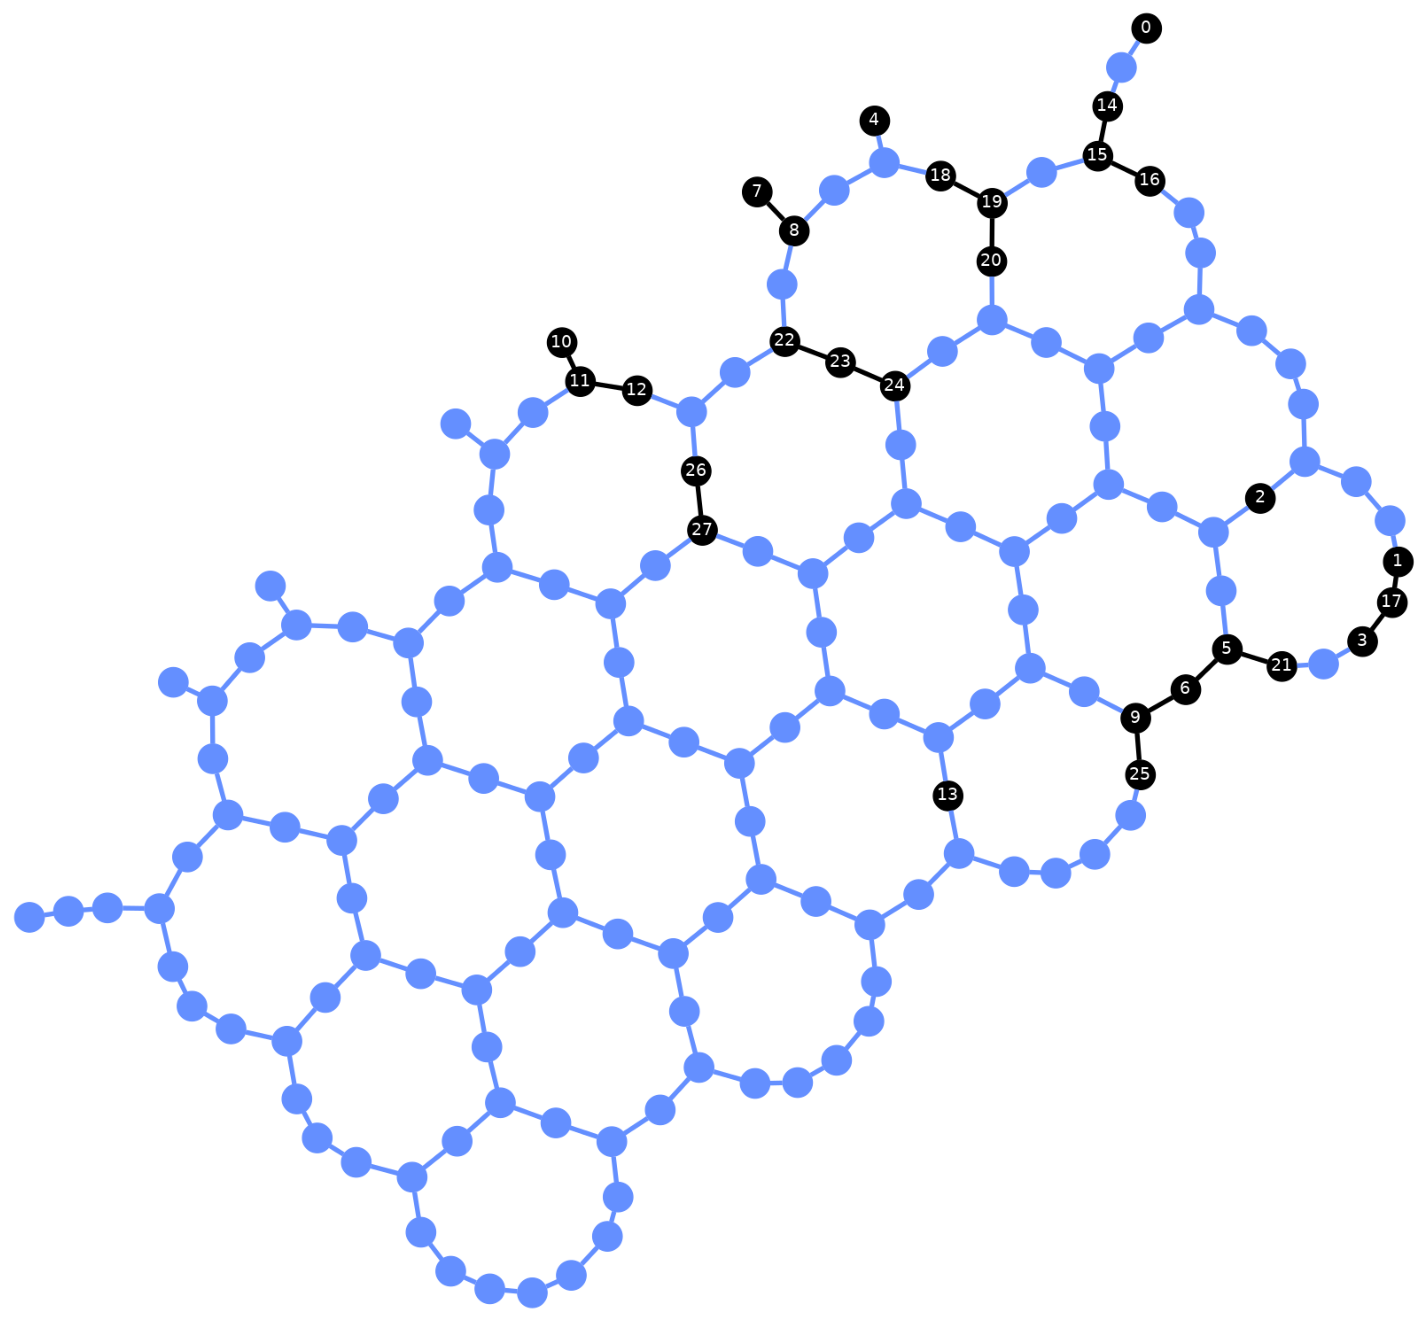

In [20]:
from qiskit.visualization import plot_circuit_layout, plot_coupling_map
plot_circuit_layout(a_circuit, backend)
#plot_coupling_map(backend=backend)